In [1]:
# Import the huggingface dataset
from datasets import load_dataset

import pandas as pd
import numpy as np

# DL
import torch
from torch.utils.data import Dataset

# Statistics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Visualization
from wordcloud import WordCloud

# For text processing
import re
import string

# For sentiment analysis
from textblob import TextBlob

# For BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
import os
print(os.getcwd())

C:\Program Files\JetBrains\PyCharm 2024.3.4\bin


In [4]:
# General dataset info
train_dl = pd.read_csv('balanced_data_files/train_dl.csv')
val_dl = pd.read_csv('balanced_data_files/val_dl.csv')
test_dl = pd.read_csv('balanced_data_files/test_dl.csv')

print(train_dl.head())
print(train_dl.shape)
print(train_dl.info())
print(train_dl.columns)

print(test_dl.head())

                                          Email Text  label
0  re : rolex order details - m 3945 s rolex : $ ...      1
1  aisb96 call for workshop proposals - - - - - -...      0
2  query : not not dear linguists , i am working ...      0
3  Update of /cvsroot/spamassassin/spamassassin/m...      0
4  URL: http://boingboing.net/#85482211\nDate: No...      0
(13054, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13054 entries, 0 to 13053
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  13041 non-null  object
 1   label       13054 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 204.1+ KB
None
Index(['Email Text', 'label'], dtype='object')
                                          Email Text  label
0   __  __ _2002-08-16   _ _____ _  __\n|  \/  (_...      0
1  produce loads of semen you always wanted ! 97 ...      1
2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3  On 14:22 29 Au

In [5]:
# checking for missing values
print("\nMissing values in training data:")
print(train_dl.isnull().sum())

print("\nMissing values in validation data:")
print(val_dl.isnull().sum())

print("\nMissing values in test data:")
print(test_dl.isnull().sum())


Missing values in training data:
Email Text    13
label          0
dtype: int64

Missing values in validation data:
Email Text    2
label         0
dtype: int64

Missing values in test data:
Email Text    1
label         0
dtype: int64


In [6]:
# Fill any missing text values
train_dl['Email Text'] = train_dl['Email Text'].fillna('')
val_dl['Email Text'] = val_dl['Email Text'].fillna('')
test_dl['Email Text'] = test_dl['Email Text'].fillna('')

PermissionError: [Errno 13] Permission denied: 'phish_wordcloud.png'

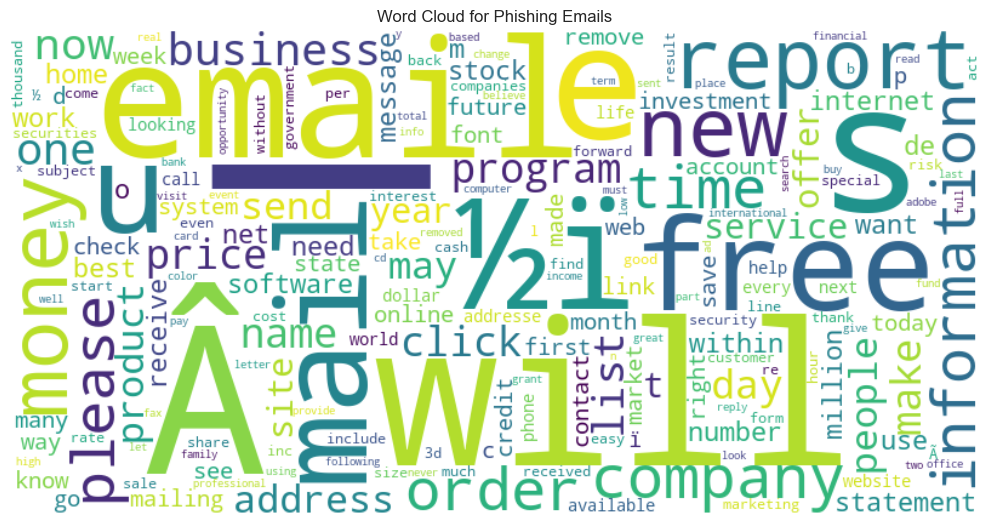

In [10]:
# Wordcloud to visualize the data
def generate_wordcloud(data, title, filename):
    # Combine all text
    all_text = ' '.join(data['Email Text'])

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=200,
                         collocations=False,
                         contour_width=3,
                         contour_color='steelblue').generate(all_text)

    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Generate word clouds for spam and ham emails
spam_emails = train_dl[train_dl['label'] == 1]
ham_emails = train_dl[train_dl['label'] == 0]

generate_wordcloud(spam_emails, 'Word Cloud for Phishing Emails', 'phish_wordcloud.png')
generate_wordcloud(ham_emails, 'Word Cloud for Safe Emails', 'safe_wordcloud.png')

In [11]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000,  # Limit features
                                  stop_words='english',  # Remove common English stop words
                                  min_df=5,  # Minimum document frequency
                                  max_df=0.7,  # Maximum document frequency
                                  ngram_range=(1, 2))  # Include unigrams and bigrams

# Extract features and target variables
X_train = train_dl['Email Text']
y_train = train_dl['label']
X_val = val_dl['Email Text']
y_val = val_dl['label']
X_test = test_dl['Email Text']
y_test = test_dl['label']

# Transform the data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nTF-IDF feature matrix shape:", X_train_tfidf.shape)


TF-IDF feature matrix shape: (13054, 5000)


In [12]:
# For checking class distribution in your target labels
print(y_train.value_counts())
print(y_test.value_counts())


label
0    7924
1    5130
Name: count, dtype: int64
label
0    1699
1    1099
Name: count, dtype: int64


PermissionError: [Errno 13] Permission denied: 'top_tfidf_terms.png'

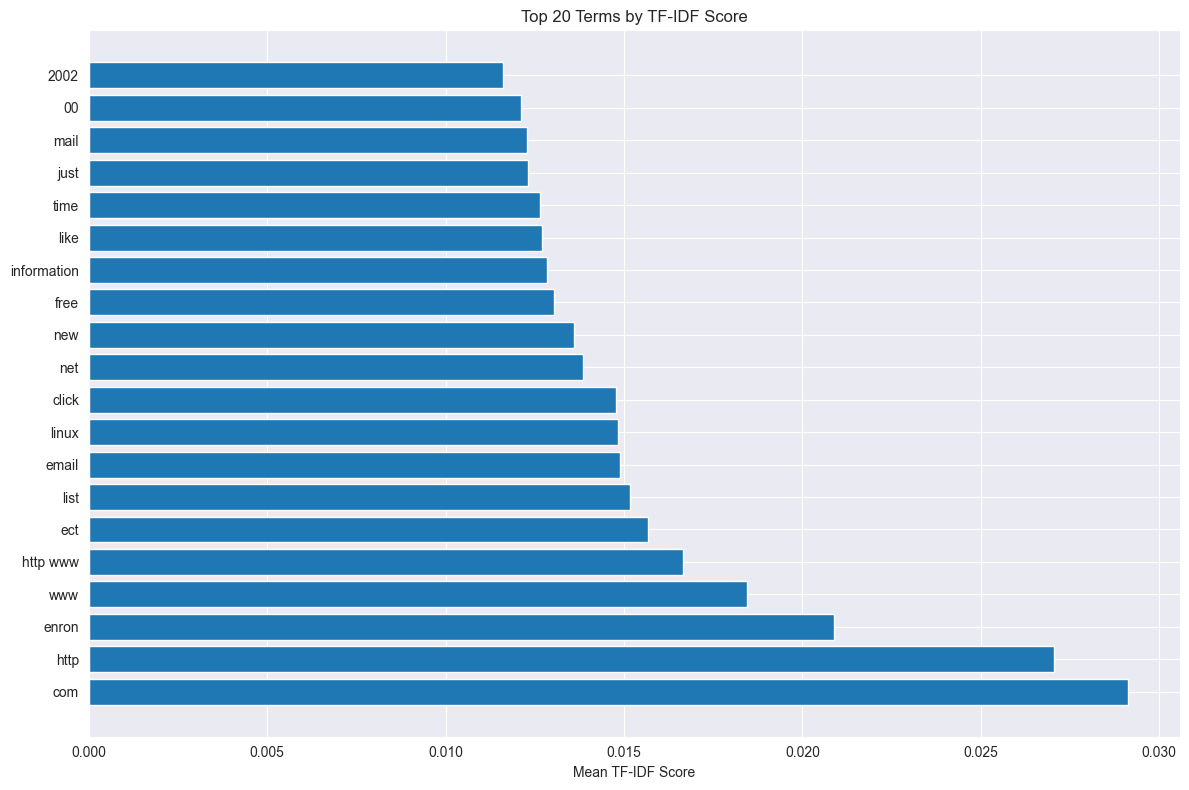

In [13]:
# Step 3: Visualize the most common terms based on TF-IDF scores
def plot_top_features(vectorizer, title, filename, top_n=20):
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Calculate mean TF-IDF score for each term
    tfidf_means = X_train_tfidf.mean(axis=0).A1

    # Get indices of top features
    top_indices = tfidf_means.argsort()[-top_n:][::-1]
    top_features = feature_names[top_indices]
    top_scores = tfidf_means[top_indices]

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(top_features, top_scores)
    plt.xlabel('Mean TF-IDF Score')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_top_features(tfidf_vectorizer, 'Top 20 Terms by TF-IDF Score', 'top_tfidf_terms.png')

In [14]:
# ANN (MLP), without hyperparam tuning

mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                   activation='relu',
                   solver='adam',
                   alpha=0.0001,
                   batch_size=64,
                   learning_rate_init=0.001,
                   max_iter=50,
                   early_stopping=True,
                   random_state=42,
                   verbose=True)

# Train the model
mlp.fit(X_train_tfidf, y_train)

Iteration 1, loss = 0.21900469
Validation score: 0.973201
Iteration 2, loss = 0.04878612
Validation score: 0.971669
Iteration 3, loss = 0.03021940
Validation score: 0.972435
Iteration 4, loss = 0.02480002
Validation score: 0.970904
Iteration 5, loss = 0.02375474
Validation score: 0.957887
Iteration 6, loss = 0.02293838
Validation score: 0.970138
Iteration 7, loss = 0.02215060
Validation score: 0.970138
Iteration 8, loss = 0.02185455
Validation score: 0.971669
Iteration 9, loss = 0.02144040
Validation score: 0.969372
Iteration 10, loss = 0.02174228
Validation score: 0.971669
Iteration 11, loss = 0.02154464
Validation score: 0.970138
Iteration 12, loss = 0.02152650
Validation score: 0.971669
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=(100, 50),
              max_iter=50, random_state=42, verbose=True)

In [15]:
#ANN with hyperparam tuning
from sklearn.model_selection import RandomizedSearchCV

ann_hyperparams = {
    'hidden_layer_sizes': [(100,), (100, 50), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01]
}

mlp_cv = RandomizedSearchCV(
    MLPClassifier(random_state=42, early_stopping=True, max_iter=200),
    ann_hyperparams,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)

mlp_cv.fit(X_train_tfidf, y_train)
print(f"Best parameters: {mlp_cv.best_params_}")

D:\.venv\Lib\site-packages\sklearn\model_selection\_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


Best parameters: {'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (128, 64), 'alpha': 0.0001, 'activation': 'relu'}


In [16]:
# Step 5: Evaluate on validation set
y_val_pred = mlp.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9711

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1699
           1       0.95      0.98      0.96      1099

    accuracy                           0.97      2798
   macro avg       0.97      0.97      0.97      2798
weighted avg       0.97      0.97      0.97      2798



In [14]:
# Step 5: Evaluate on validation set
y_val_pred = mlp_cv.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9718

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1699
           1       0.95      0.98      0.96      1099

    accuracy                           0.97      2798
   macro avg       0.97      0.97      0.97      2798
weighted avg       0.97      0.97      0.97      2798



PermissionError: [Errno 13] Permission denied: 'confusion_matrix_val.png'

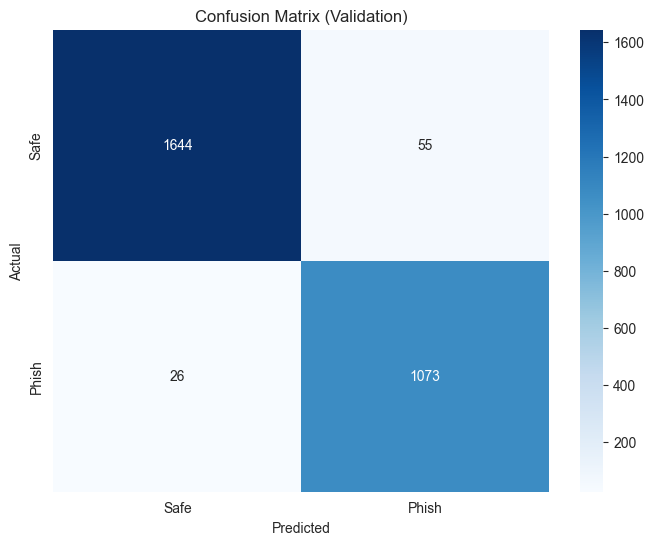

In [17]:
# Confusion matrix for validation set
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe', 'Phish'],
            yticklabels=['Safe', 'Phish'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.savefig('confusion_matrix_val.png')
plt.show()



Test Accuracy: 0.9625

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1699
           1       0.94      0.97      0.95      1099

    accuracy                           0.96      2798
   macro avg       0.96      0.96      0.96      2798
weighted avg       0.96      0.96      0.96      2798



PermissionError: [Errno 13] Permission denied: 'confusion_matrix_test.png'

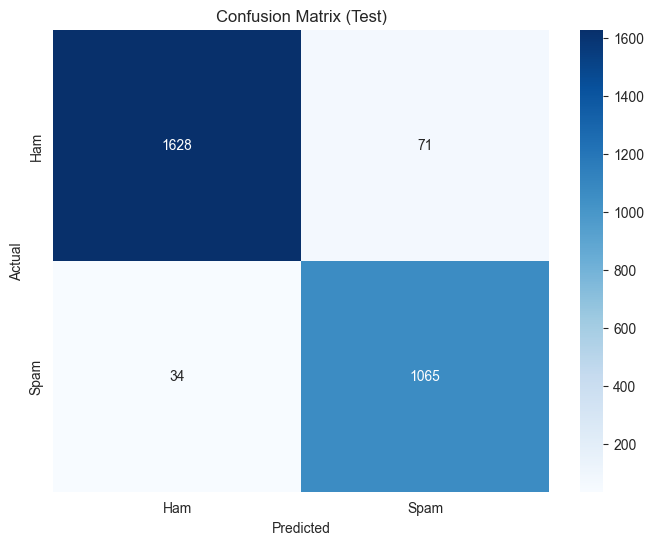

In [18]:
# For test set
y_test_pred = mlp.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.savefig('confusion_matrix_test.png')
plt.show()

In [19]:
# For test set
y_test_pred = mlp_cv.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.9639

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1699
           1       0.94      0.97      0.95      1099

    accuracy                           0.96      2798
   macro avg       0.96      0.96      0.96      2798
weighted avg       0.96      0.96      0.96      2798



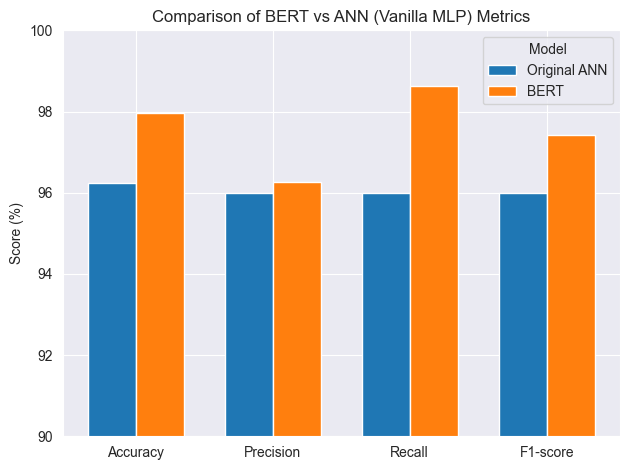

In [22]:
# Visualizing both BERT and ANN (4.3)

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
ann_scores = [96.25, 96.0, 96.0, 96.0]
bert_scores = [97.96, 96.27, 98.63, 97.43]

# Iterates through the labels obtaining the value for our X-axis
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
# Plot bars for each model
ax.bar([p - width/2 for p in x], ann_scores, width=width, label='Original ANN')
ax.bar([p + width/2 for p in x], bert_scores, width=width, label='BERT')

# Labels and legend for visual clarity
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Score (%)')
ax.set_ylim(90, 100)
ax.legend(title='Model')

plt.title('Comparison of BERT vs ANN (Vanilla MLP) Metrics')
plt.tight_layout()
plt.show()

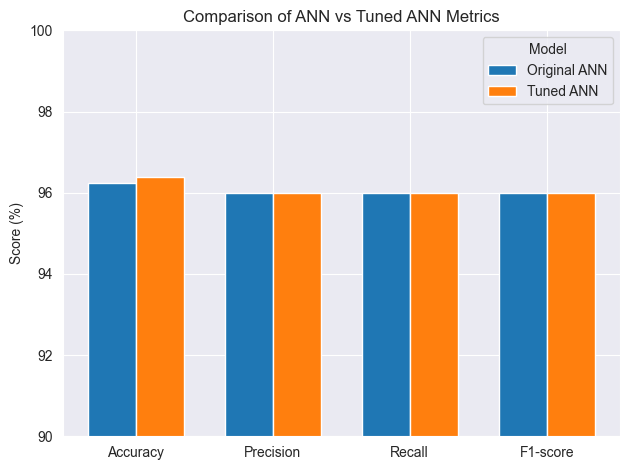

In [24]:
import matplotlib.pyplot as plt

# Metric values for ANN and Tuned ANN
# Manually inputted in order to avoid errors
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
ann_scores = [96.25, 96.0, 96.0, 96.0]
tuned_scores = [96.39, 96.0, 96.0, 96.0]

# Iterates through the labels obtaining the value for our X-axis
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
# Plot bars for each model
ax.bar([p - width/2 for p in x], ann_scores, width=width, label='Original ANN')
ax.bar([p + width/2 for p in x], tuned_scores, width=width, label='Tuned ANN')

# Labels and legend for visual clarity
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Score (%)')
ax.set_ylim(90, 100)
ax.legend(title='Model')

plt.title('Comparison of ANN vs Tuned ANN Metrics')
plt.tight_layout()
plt.show()


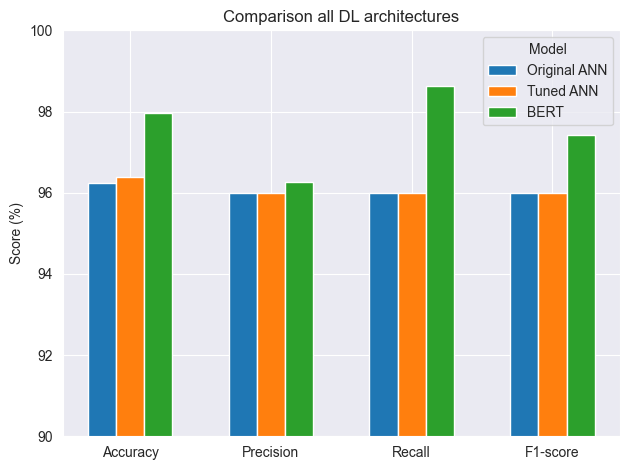

In [28]:
# Figure 4.7 (BERT, ANN, Tuned ANN)

# Manually inputted in order to avoid errors
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
ann_scores = [96.25, 96.0, 96.0, 96.0]
tuned_scores = [96.39, 96.0, 96.0, 96.0]
bert_scores = [97.96, 96.27, 98.63, 97.43]

# Iterates through the labels obtaining the value for our X-axis
x = range(len(labels))
width = 0.2

fig, ax = plt.subplots()
# Plot bars for each model
ax.bar([p - width for p in x], ann_scores, width=width, label='Original ANN')
ax.bar(x, tuned_scores, width=width, label='Tuned ANN')
ax.bar([p + width for p in x], bert_scores, width=width, label='BERT')

# Labels and legend for visual clarity
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Score (%)')
ax.set_ylim(90, 100)
ax.legend(title='Model')

plt.title('Comparison all DL architectures')
plt.tight_layout()
plt.show()
